# Sigmoid Curves for DWM Penalty
This is a worksheet that was used to test S-curve (sigmoid functions) for the decision window penalty.  The idea is that we want almost no penalty for stepping outside the window by one minute, then we want to have is eventually ramp up to a maximum value

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# This was just created by hand, to get a curve
# You could do these on graph paper, by hand
x_data = np.array([650, 720, 800, 850, 900, 950, 1000, 1050, 1100, 1200])
y_data = np.array([0.0, 0.0, 2.0, 5, 12, 15, 20, 22, 25, 25])

## Fit a 4-parameter Sigmoid curve

In [3]:
def sigmoid4(x, max_val ,x0, slope, b):
    y = max_val / (1 + np.exp(-slope * (x-x0))) + b
    return y

p0 = [max(y_data), np.median(x_data), 0.1, min(y_data)] # this is a mandatory initial guess
popt, pcov = curve_fit(sigmoid4, x_data, y_data, p0, method='dogbox')
[round(float(c), 2) for c in popt]

[26.21, 917.2, 0.02, -0.84]

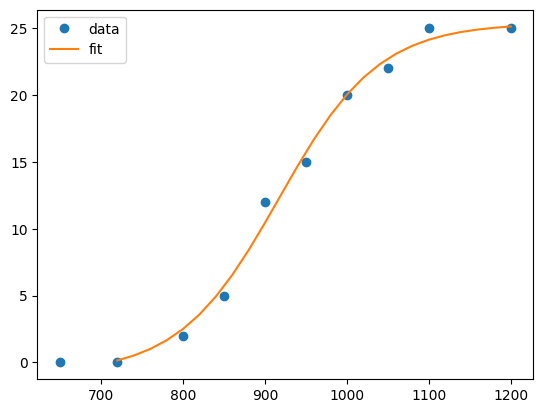

In [4]:
x = np.linspace(720, 1200, num=25)
y = sigmoid4(x, *popt)

plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x,y, label='fit')
#plt.ylim(0, 1.3)
plt.legend(loc='best')
plt.show()

## Fit a 3-Parameter Sigmoid Curve

In [5]:
def sigmoid3(x, max_val, slope, x0):
    return max_val / (1 + np.exp(-slope * (x - x0)))

p0 = [max(y_data), 0.1, np.median(x_data)] # this is a mandatory initial guess
popt3, pcov3 = curve_fit(sigmoid3, x_data, y_data, p0, method='dogbox')
[round(float(c), 2) for c in popt3]

[25.15, 0.02, 920.94]

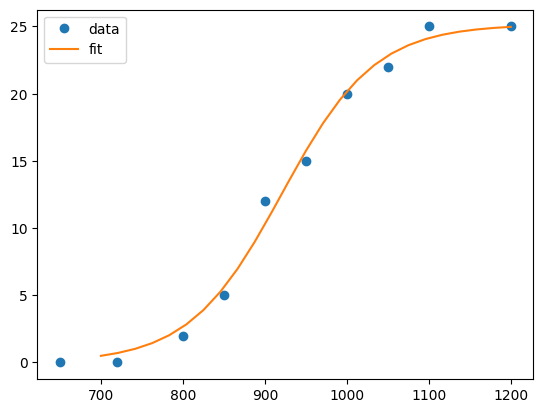

In [6]:
x = np.linspace(700, 1200, num=25)
y = sigmoid3(x, *popt3)

plt.plot(x_data, y_data, 'o', label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.show()

### Notes
1. The x0 value is approximately the midpoint between the end of the window (720) and where the curve reaches the maximum value (1100)
2. I think the 3-parameter curve will suffice for our purposes
3. The initial guess of 0.1 for the slope works pretty well.  If you make this too big then you'll get numerical overflow warnings for the curve fit, although it usually converges quite well.

## Put it all Together
The idea is to have a curve of fixed width, such as -100 to 100, then get the slope parameter.  We can then translate the curve along the x-axis and/or flip it as needed.

In [7]:
# This was just created by hand, to get a curve
x_data2 = np.linspace(-100, 100, 10)
y_data2 = np.array([0.0, 0.0, 2.0, 5, 12, 15, 20, 22, 25, 25])

In [8]:
p0 = [max(y_data2), 0.1, np.median(x_data2)] # this is a mandatory initial guess
popt, pcov = curve_fit(sigmoid3, x_data2, y_data2, p0, method='dogbox')
[round(float(c), 2) for c in popt]

[25.18, 0.04, -1.55]

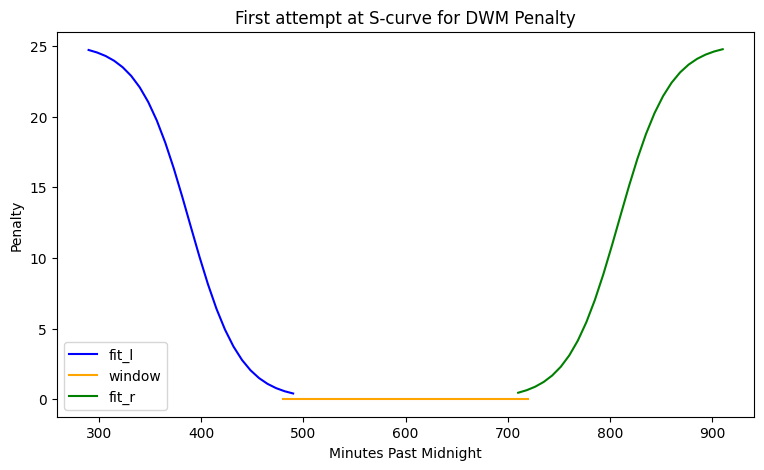

In [9]:
plt.figure(figsize=(9, 5))
x = np.linspace(-100, 100, num=25)
y = sigmoid3(x, *popt3)

# LH side has the slope flipped
left_center = (100 + 480) / 2.0 + 100
parm_l = np.array([popt[0], -popt[1], popt[2]])
yl = sigmoid3(x, *parm_l)
plt.plot(x+left_center, yl, label='fit_l', color="blue")

# Decision window
xc = np.linspace(480, 720, 5)
yc = np.array([0, 0, 0, 0, 0])
plt.plot(xc, yc, label='window', color="orange")

# RH side is just translated
right_center = (720 + 1100) / 2.0 - 100
yr = sigmoid3(x, *popt)
plt.plot(x+right_center, yr, label='fit_r', color="green")
plt.legend(loc='best')
plt.title("First attempt at S-curve for DWM Penalty")
plt.xlabel("Minutes Past Midnight")
plt.ylabel("Penalty")
plt.show()

## Slope Versus Offset
Here's how the parameters interact and what happens when they're mismatched:
1. On the left we have a lower slope but kept the same offset.  You can see that the if we now depart one minute before the window there will be step function in the penalty.  If you want a lower slope, you should increase the offset (will shift the LH curve to the left)
2. On the right we have a higher slope but kept the same offset.  You can see that the if we now arrive well after the window without a penalty.  If you want a higher slope, you should decrease the offset, this will shift the RH curve to the left

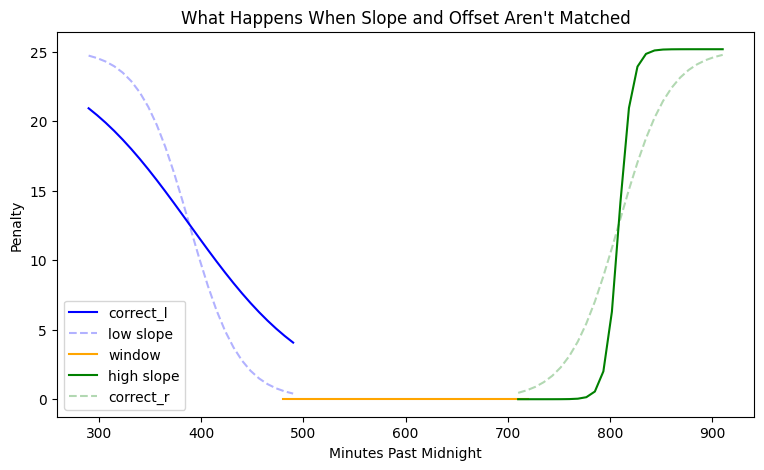

In [11]:
plt.figure(figsize=(9, 5))
x = np.linspace(-100, 100, num=25)
y = sigmoid3(x, *popt3)

# LH side has the slope flipped and half the slope
left_center = (100 + 480) / 2.0 + 100
parm_l2 = np.array([popt[0], -popt[1] * 0.4, popt[2]])
yl2 = sigmoid3(x, *parm_l2)
plt.plot(x+left_center, yl2, label='correct_l', color="blue")
plt.plot(x+left_center, yl, label='low slope', color="blue", linestyle="dashed", alpha=0.3)

# Decision window
xc = np.linspace(480, 720, 5)
yc = np.array([0, 0, 0, 0, 0])
plt.plot(xc, yc, label='window', color="orange")

# RH side is translated and I've double the slope
right_center = (720 + 1100) / 2.0 - 100
parm_r2 = np.array([popt[0], popt[1] * 4, popt[2]])
yr2 = sigmoid3(x, *parm_r2)
plt.plot(x+right_center, yr2, label='high slope', color="green")
plt.plot(x+right_center, yr, label='correct_r', color="green", linestyle="dashed", alpha=0.3)
plt.legend(loc='best')
plt.title("What Happens When Slope and Offset Aren't Matched")
plt.xlabel("Minutes Past Midnight")
plt.ylabel("Penalty")
plt.show()